## Session 5 Assignment:

1. 99.4% validation accuracy (consistent in last few epochs not a one-time achievement)
2. Less than 10k parameters
3. Less than or equal to 15 epochs
4. Do it in minimum 5 steps

* Keep Receptive field calculations handy for each of the models.
* Each file for each of the 5 steps and must have "target, result, analysis" block (either at the start or the end) and upload on github.







### File 1:
Target:
* Check the setup (check comments, libraries etc)
* Set Transforms (basics like To_Tensor, Normalize)
* Set DataLoader (later create your own api when these functions are in separate files, one file is heavy)
* Set Basic Working Code
* Set Basic Training and Test loop

Results:
* Parameters: 6.3M
* Training Accuracy: 99.95
* Testing Accuracy: 99.12

Analysis:
* Model is heavy for a small dataset for MNIST.
* Overfitting but we will change the model. (0.83 diff)


## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


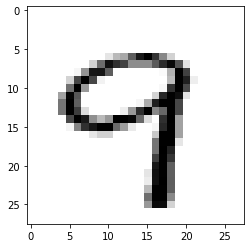

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

## Data Visualization

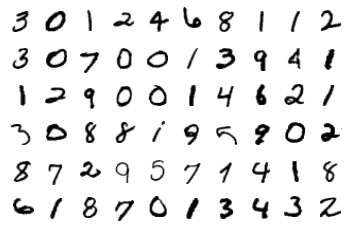

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## The Model 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1) 

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing the Model

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.01949383318424225 Batch_id=468 Accuracy=82.80: 100%|██████████| 469/469 [00:40<00:00, 11.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.003620132803916931 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:39<00:00, 11.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.007445057388395071 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.025195306167006493 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:39<00:00, 11.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.03837290033698082 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.0145470155403018 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:39<00:00, 11.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.0037206411361694336 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:40<00:00, 11.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.02047785185277462 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:39<00:00, 11.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=5.353490632842295e-05 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:40<00:00, 11.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.009150981903076172 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.0006269216537475586 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:40<00:00, 11.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=5.863110345671885e-05 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.005737006664276123 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.0013519922504201531 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=9.424487507203594e-05 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s]



Test set: Average loss: 0.0374, Accuracy: 9912/10000 (99.12%)



## Loss and Accuracy

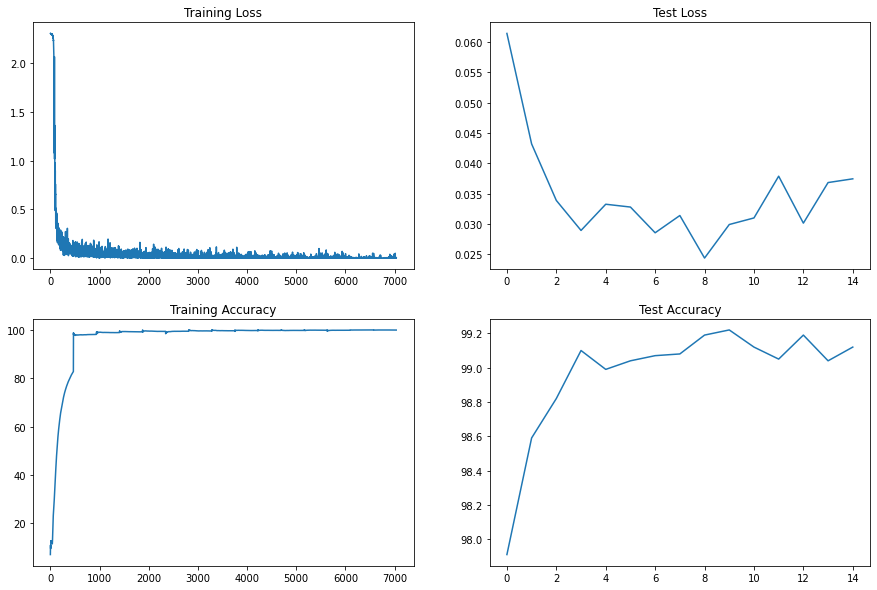

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy");

## S5 - Solution Quiz:
1. Share your targets, results and analysis for all five files. 

2. What is the Receptive field of your Fifth Model? (Between 24 and 50)

3. Have you used Data Augmentation (like rotation)?
 
 Yes

4. How many parameters your final model has? (Between 0 and 10,000)
 
 9,994

5. Have you used DropOut in the first or second code?
 
 No
 


 
 

## Quiz 5:
1. Select all which are true: Dropout:
 
 Reduces the gap between TestAcc and TrainAcc.

2. Batch Normalization should be added before the prediction layer.
 
 False

3. Batch Normalization can be added

 After Convolution

4. Select which all are true
 
 * Depending on GPU bigger batch size might speed up epochs.
 * To be on a safer side, it is always a good idea to shuffle the dataset.

5. Your model is overfitting. What all can be considered?

 * Reducing number of kernels
 * Adding Dropout
 * Adding/Changing Image Augmentation strategies.
 * Adding Batch Normalization.
 * Adding more training data (but not touching test images)

6. The images in our dataset are of size 100x100. Currently, you are at a layer where the resolution is 7x7x512. Which the best option from below (as we covered in the 10 codes)?

 Using GAP, followed by FC or 1x1 to match the number of classes.

7.  The activations for class A, B, and C before softmax were 10, 8 and 3. The difference in softmax values for class A and class B would be
 
 76%

8. The activations for class A, B, and C before softmax were 10, 8 and 3. There is only 1 image we are processing and the class happens to be B. If we are using Negative Likelihood Loss, the loss value right now is:
 
 2.127731



 
 
 









### That's all Folks!